## Ordinary Least Squares

minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


Coefficients: 
 [ 938.23786125]
Mean squared error: 2548.07
Variance score: 0.47


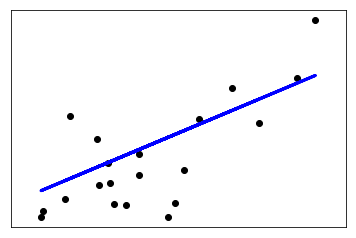

In [2]:
# load the diabetes dataset
diabetes = datasets.load_diabetes()

# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# split data to train and test set
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# split the targets to train and test set
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# train the dataset
regr.fit(diabetes_X_train, diabetes_y_train)

# predict
diabetes_y_pred = regr.predict(diabetes_X_test)

# the coefficients
print("Coefficients: \n", regr.coef_)

# the mean squared error
print('Mean squared error: %.2f' % mean_squared_error(diabetes_y_test, diabetes_y_pred))

# variance score
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()


## Ridge Regression

Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of coefficients

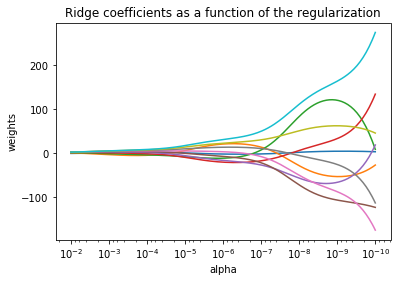

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# X is the 10x10 Hilbert matrix
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

# #############################################################################
# Compute paths
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()


## Lasso

In [5]:
# We show that linear_model.Lasso provides the same results for dense 
# and sparse data and that in the case of sparse data the speed is improved.

from time import time
from scipy import sparse
from scipy import linalg

from sklearn.datasets.samples_generator import make_regression
from sklearn.linear_model import Lasso

In [7]:
# The two Lasso implement on dense data
print ('---------- Dense matrices')

X, y = make_regression(n_samples=200, n_features=5000, random_state=0)
X_sp = sparse.coo_matrix(X)

alpha = 1
sparse_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
dense_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)

t0 = time()
sparse_lasso.fit(X_sp, y)
print('Sparse Lasso done in %fs' % (time() - t0))

t0 = time()
dense_lasso.fit(X, y)
print('Dense Lasso done in %fs' % (time() - t0))

print('Distance between coefficients : %s' % linalg.norm(sparse_lasso.coef_ - dense_lasso.coef_))

# The two Lasso implement on sparse data
print('---------- Sparse matrices')

Xs = X.copy()
Xs[Xs < 2.5] = 0.0
Xs = sparse.coo_matrix(Xs)
Xs = Xs.tocsc()

print('Matrix density %s %%' % (Xs.nnz / float(X.size) * 100))

alpha = 0.5
sparse_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
dense_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)

t0 = time()
sparse_lasso.fit(Xs, y)
print('Sparse Lasso done in %fs' % (time() - t0))

t0 = time()
dense_lasso.fit(Xs.toarray(), y)
print('Dense Lasso done in %fs' % (time() - t0))

print('Distance between coefficients : %s' % linalg.norm(sparse_lasso.coef_ - dense_lasso.coef_))


---------- Dense matrices
Sparse Lasso done in 0.406662s
Dense Lasso done in 0.156241s
Distance between coefficients : 9.189106120556946e-14
---------- Sparse matrices
Matrix density 0.6263000000000001 %
Sparse Lasso done in 0.175931s
Dense Lasso done in 1.319278s
Distance between coefficients : 4.051342370640822e-12


## Lasso model selection: Cross-Validation / AIC / BIC

In [18]:
# Use the Akaike information criterion (AIC), the Bayes Information criterion (BIC) and cross-validation 
# to select an optimal value of the regularization parameter alpha of the Lasso estimator.

import time

import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets



In [19]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

X.shape

(442, 10)

In [20]:
rng = np.random.RandomState(42)
X = np.c_[X, rng.randn(X.shape[0], 14)] # add some bad features

X.shape

(442, 24)

In [21]:
# normalize data
X /= np.sqrt(np.sum(X**2, axis=0))



In [22]:
# #############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

# #############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: divide by zero encountered in log10


Computing regularization path using the coordinate descent lasso...
Computing regularization path using the Lars lasso...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:72: RuntimeWarning: divide by zero encountered in log10


AttributeError: 'LassoLarsCV' object has no attribute 'mse_path_'